In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample-sales-data/sales_data_sample.csv


In [21]:
!pip install prophet

#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from prophet.plot import plot_plotly
import plotly.graph_objs as go
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose


**Install Model And Libraries Import**

In [3]:
df = pd.read_csv('/kaggle/input/sample-sales-data/sales_data_sample.csv', encoding='latin1')

# Rename for clarity
df.rename(columns={'ORDERDATE': 'OrderDate', 'SALES': 'Sales', 'PRODUCTLINE': 'ProductLine'}, inplace=True)

# Convert date
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Check unique product lines
print(df['ProductLine'].unique())


['Motorcycles' 'Classic Cars' 'Trucks and Buses' 'Vintage Cars' 'Planes'
 'Ships' 'Trains']


**Load and Preprocess Data**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



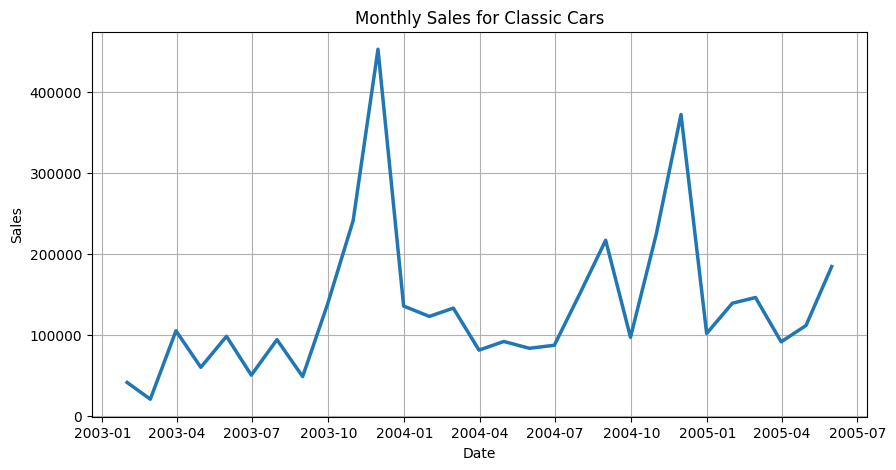

In [14]:
from prophet.plot import plot_plotly
import plotly.graph_objs as go


plot_plotly(model, forecast)
(Change as needed)
category = 'Classic Cars'
df_group = df[df['ProductLine'] == category].groupby(pd.Grouper(key='OrderDate', freq='ME'))['Sales'].sum().reset_index()

df_group.rename(columns={'OrderDate': 'ds', 'Sales': 'y'}, inplace=True)

df_group.dropna(inplace=True)

plt.figure(figsize=(10,5))
sns.lineplot(data=df_group, x='ds', y='y', linewidth=2.5)
plt.title(f"Monthly Sales for {category}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


**Prophet Forecast Plot**

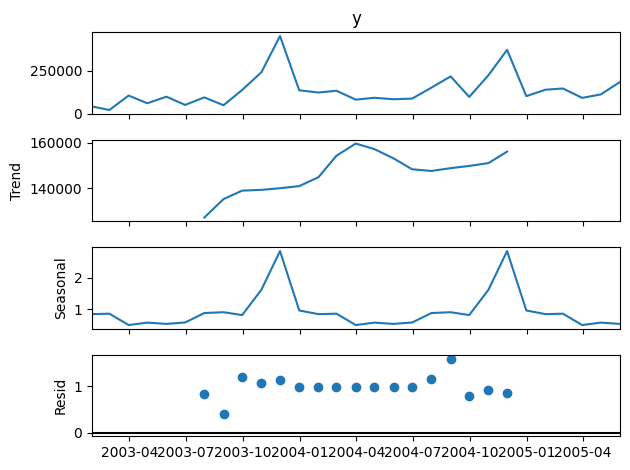

In [5]:
decomposition = seasonal_decompose(df_group.set_index('ds')['y'], model='multiplicative')
decomposition.plot()
plt.tight_layout()
plt.show()


**Time Series Decomposition**

In [11]:

model = Prophet(seasonality_mode='multiplicative')
model.fit(df_group)

future = model.make_future_dataframe(periods=6, freq='ME')
forecast = model.predict(future)

plot_plotly(model, forecast)


16:27:28 - cmdstanpy - INFO - Chain [1] start processing
16:27:29 - cmdstanpy - INFO - Chain [1] done processing


**Train Prophet with Multiplicative Seasonality**

In [7]:
predicted = forecast.iloc[:len(df_group)]

y_true = df_group['y'].values
y_pred = predicted['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 12984.95
RMSE: 15625.57
MAPE: 12.29%


**Model Evaluation**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



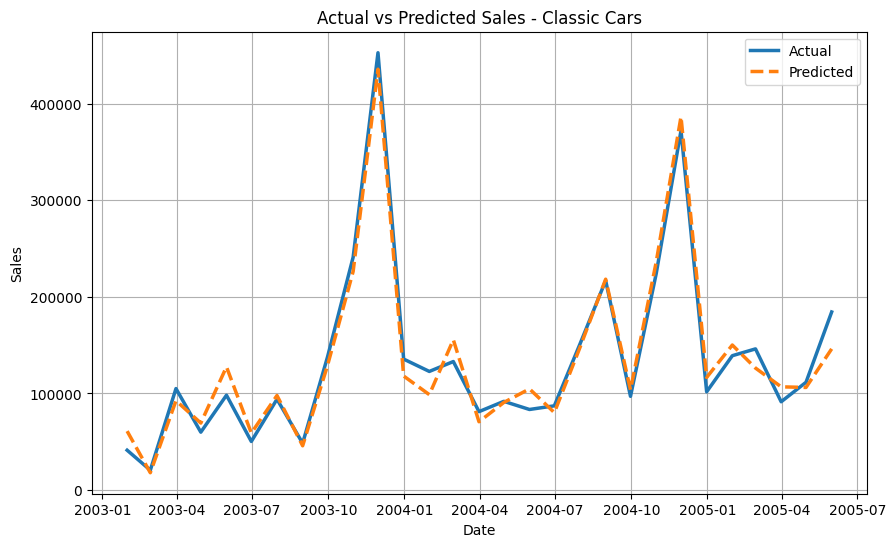

In [8]:
plt.figure(figsize=(10,6))
sns.lineplot(x=predicted['ds'], y=y_true, label='Actual', linewidth=2.5)
sns.lineplot(x=predicted['ds'], y=y_pred, label='Predicted', linestyle='--', linewidth=2.5)
plt.title(f'Actual vs Predicted Sales - {category}')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

**Actual vs Predicted Plot**

In [9]:
peak_month = forecast[['ds', 'yhat']].sort_values(by='yhat', ascending=False).iloc[0]

print(f"🔍 Forecast shows {category} sales will peak around: {peak_month['ds'].date()} with approx ${peak_month['yhat']:.2f}")

# YoY growth (if enough data)
if len(df_group) >= 24:
    this_year = df_group['y'].values[-12:]
    last_year = df_group['y'].values[-24:-12]
    growth = ((sum(this_year) - sum(last_year)) / sum(last_year)) * 100
    print(f"📈 YoY Growth in Sales: {growth:.2f}%")


🔍 Forecast shows Classic Cars sales will peak around: 2005-11-30 with approx $465133.21
📈 YoY Growth in Sales: 14.98%


**# Find month with highest predicted sales**

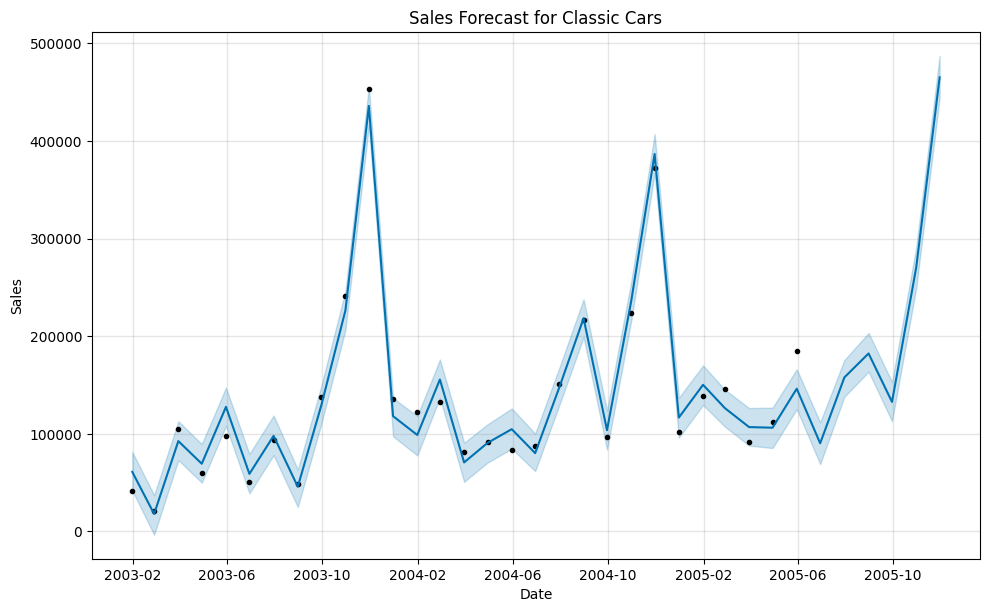

In [17]:
fig = model.plot(forecast)
plt.title(f"Sales Forecast for {category}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


**Matplotlib Forecast Plot**

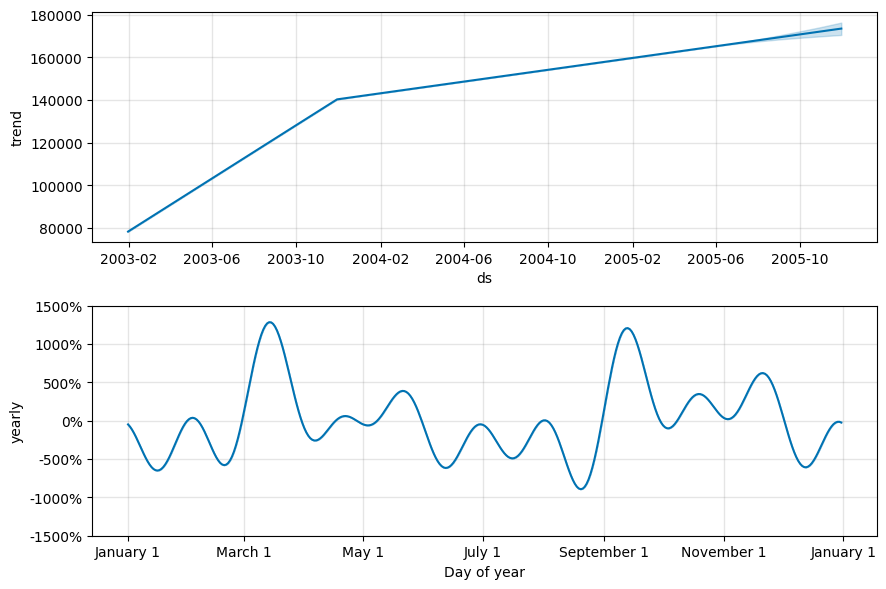

In [19]:
fig_components = model.plot_components(forecast)
plt.show()

# Save as PNG
fig_components.savefig("components_plot.png")


**Trend & Seasonality Components**